## Notebook comparing performance of different AA-autoencoder models for 1D Burgers

Consider the one-dimensional viscous Burgers' equation with Dirichlet boundary conditions which can be represented as 
\begin{align}
\dot{u} + u \frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2},\\
u(x,0) = u_0, \qquad x \in [0,L], \qquad u(0,t) = u(L.t) = 0
\end{align}

Consider the initial condition
\begin{align}
u(x,0) = \frac{x}{1 + \sqrt{\frac{1}{t_0}} \exp{\left(Re \frac{x^2}{4} \right)}},
\end{align}

Set $L=1$ and maximum time $t_{max} = 2$. An analytical solution exists and is given by 
\begin{align}
u(x,t) =  \frac{\frac{x}{t+1}}{1 + \sqrt{\frac{t+1}{t_0}} \exp{\left(Re \frac{x^2}{4t+4} \right)}}
\end{align}

where $t_0 = \exp{(Re/8)}$ and $Re = 1/\nu$. 
The spatio-temporal domain $[0,L]\times[0,t_{max}]$ is uniformly discretized into $200$ grid points and $500$ time points.

In [1]:
## Load modules
%matplotlib inline

import numpy as np
import scipy
from scipy.interpolate import RBFInterpolator, interp2d
import os
import gc
import argparse
import time
import importlib
from importlib import reload as reload
from pathlib import Path
import sys

from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler

import tensorflow as tf
print("Tensorflow v"+str(tf.__version__))
if tf.__version__ == '1.15.0':
    tf.compat.v1.enable_eager_execution()
elif tf.__version__.split('.')[0] == 2: # in ['2.2.0','2.3.0']:
    print("Setting Keras backend datatype")
    tf.keras.backend.set_floatx('float32')
    tf.debugging.set_log_device_placement(True)

from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, LSTM, InputLayer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

np.random.seed(0)

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, ScalarFormatter, FormatStrFormatter

from matplotlib import animation
matplotlib.rc('animation', html='html5')
from IPython.display import display
import matplotlib.ticker as ticker
from matplotlib import rcParams
from matplotlib.offsetbox import AnchoredText
import matplotlib.gridspec as gridspec


# Plot parameters
plt.rc('font', family='serif')
plt.rcParams.update({'font.size': 20,
                     'lines.linewidth': 2,
                     'lines.markersize':10,
                     'axes.labelsize': 16, # fontsize for x and y labels (was 10)
                     'axes.titlesize': 20,
                     'xtick.labelsize': 16,
                     'ytick.labelsize': 16,
                     'legend.fontsize': 16,
                     'axes.linewidth': 2})

import itertools
colors = itertools.cycle(['r','g','b','m','y','c'])
markers = itertools.cycle(['p','d','o','^','s','x',]) #'D','H','v','*'])

try:
    base_dir.exists()
except:
    curr_dir = Path().resolve()
    base_dir = curr_dir.parent
data_dir = base_dir / "data" / "burgers1d"
fig_dir = base_dir / "figures"
utils_dir = base_dir / "src" / "utils"
nn_dir = base_dir / "src" / "nn_model"
work_dir = base_dir / "examples"
model_dir = base_dir / "data" / "saved_models" / "ae_param_models"

sys.path.append(str(utils_dir.absolute()))
sys.path.append(str(nn_dir.absolute()))

import data_utils as du
import tf_utils as tu
import plot_utils as pu
import aa_autoencoder as aa




Tensorflow v2.5.0


In [2]:
## Uncomment the following when training for variable pulse speed
param_list = [50, 150, 300, 500, 400, 600]; flag = 'Re';    # Re as a parameter
param_train = [50, 150, 300, 500]; param_test = [400, 600 ]


model ='Burgers1D'

soln_names = ['burgers']; comp_names = {0:'burgers'}; Nc = 1 


In [3]:
load_ae_model_1 = True

if load_ae_model_1:
    pre_trained_dir = model_dir / "saved_model_AA3"
    mnum1 = str(pre_trained_dir).split('saved_model_')[1]


    ## When using custom loss functions while training, there are two ways
    ## to load a saved model
    ## 1) If loaded model will not be used for retraining, then
    ##   use 'compile=False' option while loading so that TF does
    ##   search for loss functions
    u_autoencoder1 = tf.keras.models.load_model(pre_trained_dir / "u_autoenc",compile=False)
    
    histdir1 = 'model_history_%d.npz'%mnum1
    ae_training = np.load(pre_trained_dir / histdir1)
    
    print(ae_training['msg'])

    loss_ae1 = ae_training['loss']
    vloss_ae1 = ae_training['valloss'] 
    sloss_ae1 = ae_training['shiftloss'] 
    rloss_ae1 = ae_training['reconloss'] 
    lr_ae1 = ae_training['lr']
    epochs_ae1 = ae_training['epochs']
    u_max = ae_training['umax']
    u_min = ae_training['umin']
    augment_output1 = ae_training['augment']
    
    u_autoencoder1.summary()
    

Re = [50, 150, 300, 500], train_end = 1.00*T,
Trains both shift and true decoder, Time = 53m 57s,
Step decay LR scheduler starting from 5.00e-04, Batch Size = 24,
Decaying 10% every 330 epochs. Trained for 5000 epochs,
For epochs <=1500: Loss = 0.02*Shift + 0.96*True,
For epochs > 1500: Loss = 0.24*Shift + 0.74*True,
90% NMSE + 10% Huber, L2 regularization, Scaling to [0,1],
Both Encoder input and Decoder output are augmented by parameter value

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Encoder)            multiple                  10355     
_________________________________________________________________
shift (Shift)                multiple                  10551     
_________________________________________________________________
decoder (Decoder)            multiple                  10551     
Total params: 31,457
Trainable params: 31,457
Non-trainable params:

In [4]:
load_ae_model_2 = True

if load_ae_model_2:
    pre_trained_dir = model_dir / "saved_model_AA4"
    mnum2 = str(pre_trained_dir).split('saved_model_')[1]

    ## When using custom loss functions while training, there are two ways
    ## to load a saved model
    ## 1) If loaded model will not be used for retraining, then
    ##   use 'compile=False' option while loading so that TF does
    ##   search for loss functions
    u_autoencoder2 = tf.keras.models.load_model(pre_trained_dir / "u_autoenc",compile=False)
  
    histdir2 = 'model_history_%d.npz'%mnum2
    ae_training = np.load(pre_trained_dir / histdir2)

    print(ae_training['msg'])

    loss_ae2 = ae_training['loss']
    vloss_ae2 = ae_training['valloss'] 
    sloss_ae2 = ae_training['shiftloss'] 
    rloss_ae2 = ae_training['reconloss'] 
    lr_ae2 = ae_training['lr']
    epochs_ae2 = ae_training['epochs']
    u_max2 = ae_training['umax']; assert u_max2 == u_max
    u_min2 = ae_training['umin']; assert u_min2 == u_min
    augment_output2 = ae_training['augment']
    
    u_autoencoder2.summary()


Re = [50, 150, 300, 500], train_end = 0.90*T,
Trains both shift and true decoder, Time = 58m 27s,
Step decay LR scheduler starting from 3.00e-04, Batch Size = 24,
Decaying 10% every 309 epochs. Trained for 5000 epochs,
For epochs <=1500: Loss = 0.02*Shift + 0.96*True,
For epochs > 1500: Loss = 0.14*Shift + 0.84*True,
90% NMSE + 10% Huber, L2 regularization, Scaling to [0,1],
Both Encoder input and Decoder output are augmented by parameter value

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Encoder)            multiple                  25505     
_________________________________________________________________
shift (Shift)                multiple                  25701     
_________________________________________________________________
decoder (Decoder)            multiple                  25701     
Total params: 76,907
Trainable params: 76,907
Non-trainable params:

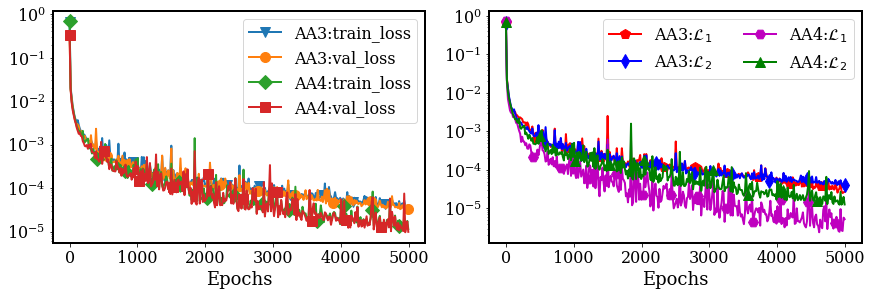

In [5]:
## Visualization losses and learning rate evolution
if load_ae_model_1 and load_ae_model_2:
    fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(12,4),constrained_layout=True)

    num_epochs_u = np.arange(epochs_ae1)
    idx_end = epochs_ae1
    ax[0].semilogy(num_epochs_u[:idx_end:15],loss_ae1[:idx_end:15],label='%s:train_loss'%mnum1,
                   marker='v',markevery=31)
    ax[0].semilogy(num_epochs_u[:idx_end:15],vloss_ae1[:idx_end:15],label='%s:val_loss'%mnum1,
                   marker='o',markevery=37)
    ax[0].semilogy(num_epochs_u[:idx_end:15],loss_ae2[:idx_end:15],label='%s:train_loss'%mnum2,
                   marker='D',markevery=27)
    ax[0].semilogy(num_epochs_u[:idx_end:15],vloss_ae2[:idx_end:15],label='%s:val_loss'%mnum2,
                   marker='s',markevery=34)
    ax[0].legend()

    ax[1].semilogy(num_epochs_u[:idx_end:15],sloss_ae1[:idx_end:15],label='%s:$\mathcal{L}_1$'%mnum1,
                   color='r', marker='p',markevery=31)
    ax[1].semilogy(num_epochs_u[:idx_end:15],rloss_ae1[:idx_end:15],label='%s:$\mathcal{L}_2$'%mnum1,
                   color='b', marker='d',markevery=37)
    ax[1].semilogy(num_epochs_u[:idx_end:15],sloss_ae2[:idx_end:15],label='%s:$\mathcal{L}_1$'%mnum2,
                   color='m', marker='H',markevery=27)
    ax[1].semilogy(num_epochs_u[:idx_end:15],rloss_ae2[:idx_end:15],label='%s:$\mathcal{L}_2$'%mnum2,
                   color='g', marker='^',markevery=34)
    ax[1].legend(ncol=2)

    for i in range(2):       
        ax[i].set_xlabel('Epochs',fontsize=18)

    plt.savefig(fig_dir+'CombBurgers1D_par%s_AEtrainingComparison_epochs%d.png'%(flag,epochs_ae1),dpi=300,bbox_inches='tight')



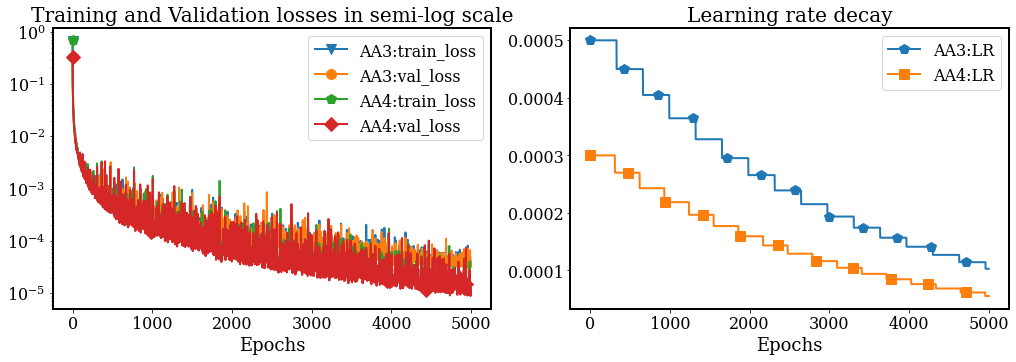

In [6]:
## Visualization losses and learning rate evolution
if load_ae_model_1 and load_ae_model_2:
    fig, ax = plt.subplots(nrows=2,ncols=2,figsize=(14,9),constrained_layout=True)

    num_epochs_u = np.arange(epochs_ae1)

    ax[0,0].semilogy(num_epochs_u[:idx_end],loss_ae1[:idx_end],label='%s:train_loss'%mnum1,marker='v',markevery=418)
    ax[0,0].semilogy(num_epochs_u[:idx_end],vloss_ae1[:idx_end],label='%s:val_loss'%mnum1,marker='o',markevery=446)
    ax[0,0].semilogy(num_epochs_u[:idx_end],loss_ae2[:idx_end],label='%s:train_loss'%mnum2,marker='p',markevery=471)
    ax[0,0].semilogy(num_epochs_u[:idx_end],vloss_ae2[:idx_end],label='%s:val_loss'%mnum2,marker='D',markevery=493)
    ax[0,0].set_title('Training and Validation losses in semi-log scale')

    ax[0,1].plot(num_epochs_u[:idx_end],lr_ae1[:idx_end],label='%s:LR'%mnum1,marker='p',markevery=428)
    ax[0,1].plot(num_epochs_u[:idx_end],lr_ae2[:idx_end],label='%s:LR'%mnum2,marker='s',markevery=471)
    ax[0,1].set_title('Learning rate decay')


    for i in range(1):
        ax[i,0].legend(); ax[i,1].legend()
        ax[i,0].set_xlabel('Epochs',fontsize=18)
        ax[i,1].set_xlabel('Epochs',fontsize=18)
    ax[1,1].remove()
    ax[1,0].remove()

#     plt.savefig(fig_dir+'CombPulse_parsigma_AEtrainingComparison2_c1.00_NMSE_epochs%d.png'%(epochs_ae1),dpi=300,bbox_inches='tight')



In [7]:
## Load snapshot data

snap_data = {}; times_offline = {}
Re = {}; 
snap_start = {}; snap_end = {}

for indx,val in enumerate(param_train):
    if flag == 'Re':
        datafile = 'Burgers1d_Nx200_Nt500_Re%.2f'%(val)+'.npz'
    data = np.load(os.path.join(data_dir, datafile))
   
    Re[indx] = float(datafile.split('_Re')[1].split('.npz')[0])
    print("\n%d: Loading snapshots for Re = %.2f "%(indx, Re[indx]))
    
    snap_data[indx], times_offline[indx], nodes, Nx, Ny, snap_start[indx], snap_end[indx] = du.read_data(data, soln_names)
    
del data
gc.collect()        


0: Loading snapshots for Re = 50.00 
Loaded 500 snapshots of dimension 200 for ['burgers']  spanning times [0.000, 0.033] mins

1: Loading snapshots for Re = 150.00 
Loaded 500 snapshots of dimension 200 for ['burgers']  spanning times [0.000, 0.033] mins

2: Loading snapshots for Re = 300.00 
Loaded 500 snapshots of dimension 200 for ['burgers']  spanning times [0.000, 0.033] mins

3: Loading snapshots for Re = 500.00 
Loaded 500 snapshots of dimension 200 for ['burgers']  spanning times [0.000, 0.033] mins


27576

In [8]:
## Prepare training snapshots

Nn = Nx

## number of steps to skip in selecting training snapshots for SVD basis
snap_incr=2

## Subsample snapshots for building reduced basis
Nt = {}
Nt_train = {}
train_end = {}
for indx,val in enumerate(param_train):
    Nt[indx] = times_offline[indx].size
    train_end[indx] = int(Nt[indx]*1.00)
    Nt_train[indx] = times_offline[indx][:train_end[indx]+1:snap_incr].size
    print('{5}: Using {0} training snapshots for {1} = {2:.2f} in time interval [{3:.2f},{4:.2f}]'.format(
            Nt_train[indx], flag, param_train[indx], times_offline[indx][:train_end[indx]+1:snap_incr][0], 
            times_offline[indx][:train_end[indx]+1:snap_incr][-1], indx))



0: Using 250 training snapshots for Re = 50.00 in time interval [0.00,2.00]
1: Using 250 training snapshots for Re = 150.00 in time interval [0.00,2.00]
2: Using 250 training snapshots for Re = 300.00 in time interval [0.00,2.00]
3: Using 250 training snapshots for Re = 500.00 in time interval [0.00,2.00]


In [9]:
def set_label(key):
    if key == 'burgers':
        ky = 'u'
    
    return ky

In [10]:
## Load shifted snapshots   
print("Generating shifted snapshots -----\n")

shifted_snap = {}
for indx,val in enumerate(param_train):
    
    shifted_snap[indx] = {}
    for key in soln_names:
        tmp = snap_data[indx][key][:,int(Nt[indx]//2)]
        shifted_snap[indx][key] = np.outer(tmp,np.ones(Nt[indx]))

        print("%d: Generating %d shifted snapshots for Re = %d, key = %s"%(indx, 
                                                            shifted_snap[indx][key].shape[1], 
                                                            Re[indx], key))
        


Generating shifted snapshots -----

0: Generating 500 shifted snapshots for Re = 50, key = burgers
1: Generating 500 shifted snapshots for Re = 150, key = burgers
2: Generating 500 shifted snapshots for Re = 300, key = burgers
3: Generating 500 shifted snapshots for Re = 500, key = burgers


In [11]:
###  ***** Prepare Autoencoder input data *******
## 1. Concatenate parametric snapshots to prepare
##    input features for AA Autoencoder training

u = np.empty((0,Nn),)
u_shift = np.empty((0,Nn),)
key = soln_names[0]

for indx,val in enumerate(param_train):
    u_snap = snap_data[indx][key][:,:train_end[indx]+1:snap_incr].T    
    u = np.vstack((u,u_snap))
    u_shift_snap = shifted_snap[indx][key][:,:train_end[indx]+1:snap_incr].T
    u_shift = np.vstack((u_shift,u_shift_snap))
    

validation_data = True
skip_start = snap_incr//2
if validation_data:
    u_val = np.empty((0,Nn),)
    u_val_shift = np.empty((0,Nn),)
    for indx,val in enumerate(param_train):
        u_val_snap = snap_data[indx][key][:,skip_start:train_end[indx]+1:snap_incr].T
        u_val_shift_snap = shifted_snap[indx][key][:,skip_start:train_end[indx]+1:snap_incr].T
        u_val = np.vstack((u_val, u_val_snap))
        u_val_shift = np.vstack((u_val_shift, u_val_shift_snap))
    

In [12]:
## Scale Input Features to lie between [0,1]

scaling=True

if scaling:
    u, u_shift, _, _ = du.data_scaler(u, u_shift, u_max, u_min)

    if validation_data:
        u_val, u_val_shift, _, _ = du.data_scaler(u_val, u_val_shift, u_max, u_min)
        
else:
    pass



In [13]:
###  ***** Prepare Autoencoder input data *******
## 2. Augment input feature states with scaled 
##    parameter values

u_sigma = np.empty((0,1),)
u_shift_sigma = np.empty((0,1),)

p_max = np.asarray(param_list).max()
for indx,val in enumerate(param_train/p_max):
    u_sigma = np.vstack((u_sigma,val*np.ones((Nt_train[indx],1))))
    u_shift_sigma = np.vstack((u_shift_sigma,val*np.ones((Nt_train[indx],1)) ))
    
u = np.hstack(( u,u_sigma))
u_shift = np.hstack(( u_shift, u_shift_sigma))


if validation_data:
    u_val_sigma = np.empty((0,1),)
    u_val_shift_sigma = np.empty((0,1),)
    for indx,val in enumerate(param_train/p_max):
        val_steps = np.minimum(times_offline[indx][skip_start:train_end[indx]+1:snap_incr].size, Nt_train[indx])
        u_val_sigma = np.vstack((u_val_sigma, val*np.ones((val_steps,1)) ))
        u_val_shift_sigma = np.vstack((u_val_shift_sigma, val*np.ones((val_steps,1)) ))
        
        
    u_val = np.hstack(( u_val, u_val_sigma))
    u_val_shift = np.hstack(( u_val_shift, u_val_shift_sigma))



In [14]:
### Predict using data points not in training set
ky = soln_names[0]
pred_shift = {}; pred_recon = {}

for mnum in ['AA3', 'AA4']:
    if mnum == 'AA3':
        u_autoencoder = u_autoencoder1; augment_out = True; 
    elif mnum == 'AA4':
        u_autoencoder = u_autoencoder2; augment_out = True; 
        
    pred_shift[mnum] = {}; pred_recon[mnum] = {}
    for iparam,val in enumerate(param_train):
        iparam = param_train.index(val); 
        print("Testing %s predictions for Re = %.2f (parameter number = %d)"%(mnum,val, iparam))

        u_test = snap_data[iparam][ky][:,:snap_end[iparam]+1].T
        u_shift_test = shifted_snap[iparam][ky][:,:snap_end[iparam]+1].T
        if scaling:
            u_test, u_shift_test, _, _ = du.data_scaler(u_test, u_shift_test, u_max, u_min)

        u_test = np.hstack(( u_test, val/p_max*np.ones((Nt[iparam],1)) ))
        u_shift_test = np.hstack(( u_shift_test, val/p_max*np.ones((Nt[iparam],1)) ))


        encoded_u_test = u_autoencoder.encoder(u_test).numpy()
        decoded_u_test = u_autoencoder.shift(encoded_u_test).numpy()
        recon_u_test = u_autoencoder.decoder(encoded_u_test).numpy()

        pred_shift[mnum][iparam] = {}
        pred_recon[mnum][iparam] = {}
        if augment_out:
            pred_recon[mnum][iparam][ky] = du.scaler_inverse(recon_u_test[:,:-1], u_max, u_min, scaling=scaling).T
            pred_shift[mnum][iparam][ky] = du.scaler_inverse(decoded_u_test[:,:-1], u_max, u_min, scaling=scaling).T
        else:
            pred_recon[mnum][iparam][ky] = du.scaler_inverse(recon_u_test[:,:], u_max, u_min, scaling=scaling).T
            pred_shift[mnum][iparam][ky] = du.scaler_inverse(decoded_u_test[:,:], u_max, u_min, scaling=scaling).T
    print('')


Testing AA3 predictions for Re = 50.00 (parameter number = 0)
Testing AA3 predictions for Re = 150.00 (parameter number = 1)
Testing AA3 predictions for Re = 300.00 (parameter number = 2)
Testing AA3 predictions for Re = 500.00 (parameter number = 3)

Testing AA4 predictions for Re = 50.00 (parameter number = 0)
Testing AA4 predictions for Re = 150.00 (parameter number = 1)
Testing AA4 predictions for Re = 300.00 (parameter number = 2)
Testing AA4 predictions for Re = 500.00 (parameter number = 3)



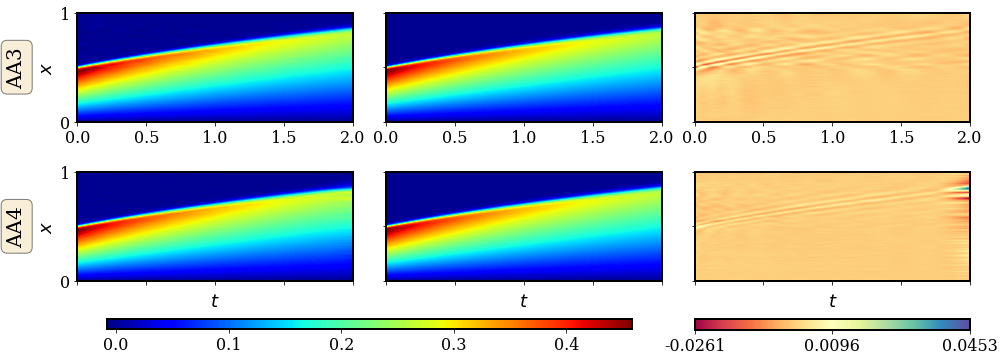

In [15]:
## Compare true snapshots predictions with two AA models
ky = soln_names[0]; 
np.random.seed(2021)
imnum1 = 'AA3'; imnum2 = 'AA4'
iparam = 3

pu.plot_spcaetime_1d(pred_recon[imnum1][iparam][ky],snap_data[iparam][ky],
                  pred_recon[imnum2][iparam][ky],snap_data[iparam][ky],
                  label1 = imnum1, label2 = imnum2)

# plt.savefig(fig_dir+'%s_%s_Re%.1f_AErecon_swish_NMSE.png'%(model,mnum1+mnum2,Re[iparam]),
#             dpi=300,bbox_inches='tight')



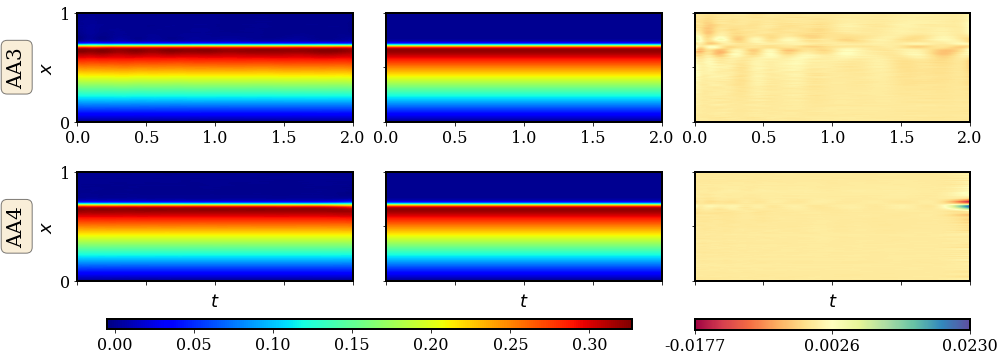

In [16]:
## Compare shifted snapshots predictions with two AA models
ky = soln_names[0]; 
np.random.seed(2021)
# imnum1 = 'AA3'; imnum2 = 'AA4'
# iparam = 3

pu.plot_spcaetime_1d(pred_shift[imnum1][iparam][ky],shifted_snap[iparam][ky],
                  pred_shift[imnum2][iparam][ky],shifted_snap[iparam][ky],
                  label1 = imnum1, label2 = imnum2)

# plt.savefig(fig_dir+'%s_%s_Re%.1f_AEshift_swish_NMSE.png'%(model,mnum1+mnum2,Re[iparam]),
#             dpi=300,bbox_inches='tight')


In [17]:
## Compute rel error for decoded prediction of shifted solutions
rel_err_shift = {}
rel_err_recon = {}
key = 'burgers'
shift_max = np.zeros(len(param_train))
recon_max = np.zeros(len(param_train))
for imnum in ['AA3', 'AA4']:
    rel_err_shift[imnum] = {}
    rel_err_recon[imnum] = {}
    for iparam,val in enumerate(param_train[:4]):
        iparam = param_train.index(val);
        true = shifted_snap[iparam][key][:,:snap_end[iparam]+1]
        true2 = snap_data[iparam][key][:,:snap_end[iparam]+1]
        rel_err_shift[imnum][iparam] = np.linalg.norm(pred_shift[imnum][iparam][key]-true,axis=0)/np.linalg.norm(true,axis=0)
        rel_err_recon[imnum][iparam] = np.linalg.norm(pred_recon[imnum][iparam][key]-true2,axis=0)/np.linalg.norm(true2,axis=0)
        
t_end = 15
for iparam,val in enumerate(param_train[:4]):
    shift_max[iparam] = np.maximum(np.amax(rel_err_shift['AA3'][iparam][:-t_end]), np.amax(rel_err_shift['AA4'][iparam][:-t_end]))
    recon_max[iparam] = np.maximum(np.amax(rel_err_recon['AA3'][iparam][:-t_end]), np.amax(rel_err_recon['AA4'][iparam][:-t_end]))


Text(0.5, 0, 'Time, $t$ ')

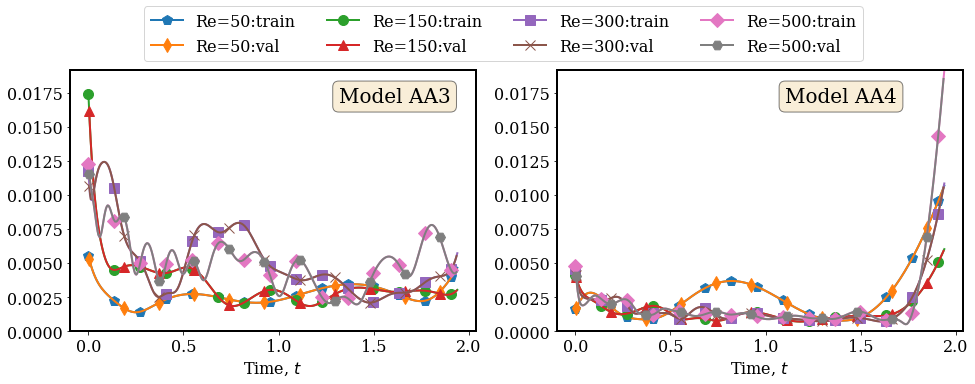

In [18]:
### Visualize relative errors for shift decoders

fig = plt.figure(figsize=(16,5))
fig.tight_layout()
fig.subplots_adjust(top=0.85)

markers = itertools.cycle(['p','d','o','^','s','x','D','H']) #,'v','*'])
    
if validation_data:
    val_skip = 2
else:
    val_skip = 1
    
y_max = shift_max.max()

ax1 = plt.subplot(1,2,1); 
for iparam,val in enumerate(param_train[:4]):
    iparam = param_train.index(val);
    indx = times_offline[iparam][:snap_end[iparam]+1]
    val_mark = int(indx.size*1.0)-t_end
    ax1.plot(indx[:val_mark:val_skip],rel_err_shift['AA3'][iparam][:val_mark:val_skip],
            label='%s=%.0f:train'%(flag,val), 
             marker=next(markers),markevery=17,markersize=10,)
    if validation_data:
        ax1.plot(indx[1:val_mark:val_skip],rel_err_shift['AA3'][iparam][1:val_mark:val_skip],
                label='%s=%.0f:val'%(flag,val), 
                 marker=next(markers),markevery=23,markersize=10,)
ax1.set_ylim(top=y_max, bottom = 0)

# place a text box in upper left in axes coords
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax1.text(0.8, 0.9, 'Model AA3', bbox=props, horizontalalignment='center', 
         verticalalignment='center', transform=ax1.transAxes)


ax2 = plt.subplot(1,2,2); 
for iparam,val in enumerate(param_train[:4]):
    iparam = param_train.index(val);
    indx = times_offline[iparam][:snap_end[iparam]+1]
    val_mark = int(indx.size*1.0)-t_end  
    ax2.plot(indx[:val_mark:val_skip],rel_err_shift['AA4'][iparam][:val_mark:val_skip],
                marker=next(markers), markevery=17,markersize=10,)
    if validation_data:
        ax2.plot(indx[1:val_mark:val_skip],rel_err_shift['AA4'][iparam][1:val_mark:val_skip],
                    marker=next(markers), markevery=23,markersize=10,)
ax2.set_ylim(top=y_max, bottom = 0)
ax2.text(0.7, 0.9, 'Model AA4', bbox=props, horizontalalignment='center', 
         verticalalignment='center', transform=ax2.transAxes)
   
lg = fig.legend(ncol=len(param_train),bbox_to_anchor=(0.82, 1.05))
ax1.set_xlabel('Time, $t$ '); ax2.set_xlabel('Time, $t$ ')
    

# plt.savefig(fig_dir+'%s_%s_par%s_TrainShiftAErel_err_swish_NMSE.png'%(model,mnum1+mnum2,flag),dpi=300,bbox_extra_artists=(lg,),bbox_inches='tight')


Text(0.5, 0, 'Time, $t$ ')

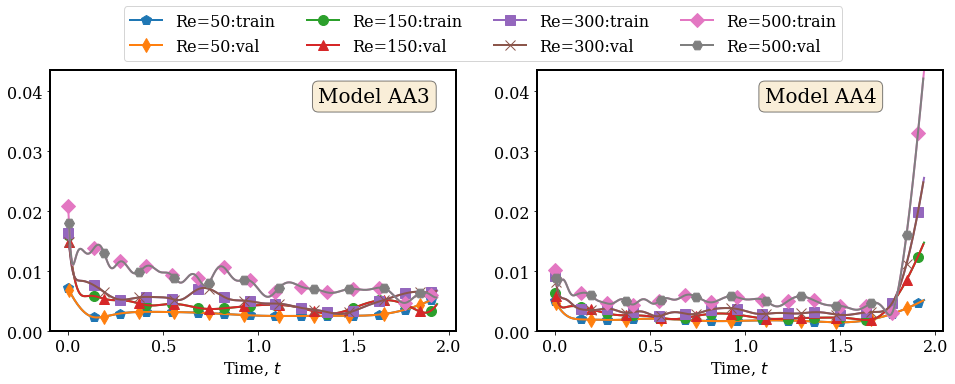

In [19]:
### Visualize relative errors for true decoders

fig = plt.figure(figsize=(16,5))
fig.tight_layout()
fig.subplots_adjust(top=0.85)

markers = itertools.cycle(['p','d','o','^','s','x','D','H']) 
    
if validation_data:
    val_skip = 2
else:
    val_skip = 1
    
y_max = recon_max.max()

ax1 = plt.subplot(1,2,1); 
for iparam,val in enumerate(param_train[:4]):
    iparam = param_train.index(val);
    indx = times_offline[iparam][:snap_end[iparam]+1]
    val_mark = int(indx.size*1.0)-t_end
    ax1.plot(indx[:val_mark:val_skip],rel_err_recon['AA3'][iparam][:val_mark:val_skip],
            label='%s=%.0f:train'%(flag,val), 
             marker=next(markers),markevery=17,markersize=10,)
    if validation_data:
        ax1.plot(indx[1:val_mark:val_skip],rel_err_recon['AA3'][iparam][1:val_mark:val_skip],
                label='%s=%.0f:val'%(flag,val), 
                 marker=next(markers),markevery=23,markersize=10,)
ax1.set_ylim(top=y_max, bottom = 0)

# place a text box in upper left in axes coords
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
ax1.text(0.8, 0.9, 'Model AA3', bbox=props, horizontalalignment='center', 
         verticalalignment='center', transform=ax1.transAxes)


ax2 = plt.subplot(1,2,2); 
for iparam,val in enumerate(param_train[:4]):
    iparam = param_train.index(val);
    indx = times_offline[iparam][:snap_end[iparam]+1]
    val_mark = int(indx.size*1.0)-t_end  
    ax2.plot(indx[:val_mark:val_skip],rel_err_recon['AA4'][iparam][:val_mark:val_skip],
                marker=next(markers), markevery=17,markersize=10,)
    if validation_data:
        ax2.plot(indx[1:val_mark:val_skip],rel_err_recon['AA4'][iparam][1:val_mark:val_skip],
                    marker=next(markers), markevery=23,markersize=10,)
ax2.set_ylim(top=y_max, bottom = 0)
ax2.text(0.7, 0.9, 'Model AA4', bbox=props, horizontalalignment='center', 
         verticalalignment='center', transform=ax2.transAxes)

  
lg = fig.legend(ncol=len(param_train),bbox_to_anchor=(0.82, 1.05))
ax1.set_xlabel('Time, $t$ '); ax2.set_xlabel('Time, $t$ ')
    

# plt.savefig(fig_dir+'%s_%s_par%s_TrainReconAErel_err_swish_NMSE.png'%(model,mnum1+mnum2,flag),dpi=300,bbox_extra_artists=(lg,),bbox_inches='tight')



In [20]:
## Evaluate predictions on a dataset with unseen parameter value

new_test = True

if new_test:
    Re_new = {}; snap_new = {}; times_new = {};
    snap_start_new, snap_end_new, Nt_new = {}, {}, {}
    shifted_snap_new = {}
    if flag == 'Re':
        for inx,val in enumerate(param_test):
            Re_new[inx] = val;
            new_data = np.load(os.path.join(data_dir,'Burgers1d_Nx200_Nt500_Re%.2f'%(Re_new[inx])+'.npz'))
            print("\nChosen parameter: %s = %f"%(flag, param_test[inx]))
    
            snap_new[inx], times_new[inx], nodes2, Nx2, Ny2, snap_start_new[inx], snap_end_new[inx] = du.read_data(new_data, soln_names)
            Nt_new[inx] = times_new[inx].size
            
            shifted_snap_new[inx] = {}
            for key in soln_names:
                tmp = snap_new[inx][key][:,int(Nt_new[inx]//2)].reshape((Nn,-1))
                shifted_snap_new[inx][key] = np.outer(tmp,np.ones(Nt_new[inx]))

  
    del new_data
    gc.collect()




Chosen parameter: Re = 400.000000
Loaded 500 snapshots of dimension 200 for ['burgers']  spanning times [0.000, 0.033] mins

Chosen parameter: Re = 600.000000
Loaded 500 snapshots of dimension 200 for ['burgers']  spanning times [0.000, 0.033] mins


In [21]:
pred_shift_new = {}; pred_recon_new = {}

ky = soln_names[0]

for mnum in ['AA3', 'AA4']:
    if mnum == 'AA3':
        u_autoencoder = u_autoencoder1; augment_out = True; 
    elif mnum == 'AA4':
        u_autoencoder = u_autoencoder2; augment_out = True; 
        
    pred_shift_new[mnum] = {}; pred_recon_new[mnum] = {}

    for inx,val in enumerate(param_test):
        print("Testing %s predictions for Re = %.2f (parameter number = %d)"%(mnum,val, inx))
        u_new = snap_new[inx][ky][:,:snap_end_new[inx]+1].T
        u_shift_new = shifted_snap_new[inx][ky][:,:snap_end_new[inx]+1].T

        if scaling:
            u_new, u_shift_new, _, _ = du.data_scaler(u_new, u_shift_new, u_max, u_min)

        u_new = np.hstack(( u_new, (param_test[inx]/p_max)*np.ones((Nt_new[inx],1)) ))
        u_shift_new = np.hstack(( u_shift_new, (param_test[inx]/p_max)*np.ones((Nt_new[inx],1)) ))


        encoded_u_new = u_autoencoder.encoder(u_new).numpy()
        decoded_u_new = u_autoencoder.shift(encoded_u_new).numpy()
        recon_u_new = u_autoencoder.decoder(encoded_u_new).numpy()


        pred_shift_new[mnum][inx] = {}; pred_recon_new[mnum][inx] = {}
        if augment_out:
            pred_shift_new[mnum][inx][ky] = du.scaler_inverse(decoded_u_new[:,:-1], u_max, u_min, scaling=scaling).T  
            pred_recon_new[mnum][inx][ky] = du.scaler_inverse(recon_u_new[:,:-1], u_max, u_min, scaling=scaling).T
        else:
            pred_shift_new[mnum][inx][ky] = du.scaler_inverse(decoded_u_new[:,:], u_max, u_min, scaling=scaling).T  
            pred_recon_new[mnum][inx][ky] = du.scaler_inverse(recon_u_new[:,:], u_max, u_min, scaling=scaling).T
    print('')

Testing AA3 predictions for Re = 400.00 (parameter number = 0)
Testing AA3 predictions for Re = 600.00 (parameter number = 1)

Testing AA4 predictions for Re = 400.00 (parameter number = 0)
Testing AA4 predictions for Re = 600.00 (parameter number = 1)



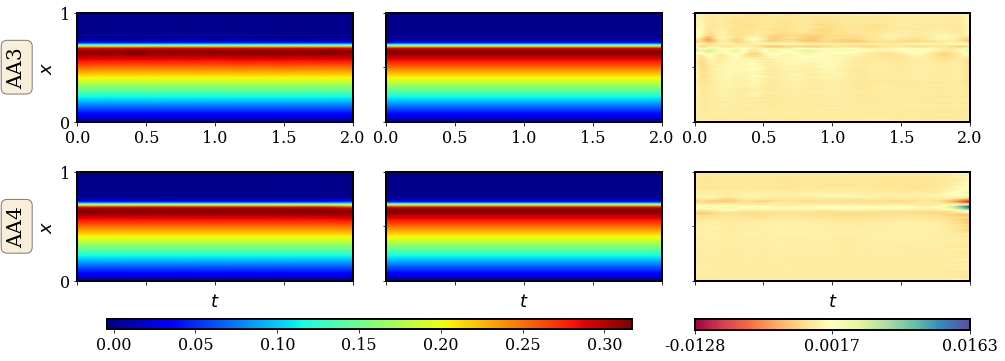

In [22]:
## Compare shifted snapshots predictions with two AA models
ky = soln_names[0]; 
np.random.seed(2021)
imnum1 = 'AA3'; imnum2 = 'AA4'
p_inx = 0

pu.plot_spcaetime_1d(pred_shift_new[imnum1][p_inx][ky],shifted_snap_new[p_inx][ky],
                  pred_shift_new[imnum2][p_inx][ky],shifted_snap_new[p_inx][ky],
                  label1 = imnum1, label2 = imnum2)

# plt.savefig(fig_dir+'%s_%s_Re%.1f_AEshift_swish_NMSE.png'%(model,mnum1+mnum2,Re_new[p_inx]),
#             dpi=300,bbox_inches='tight')



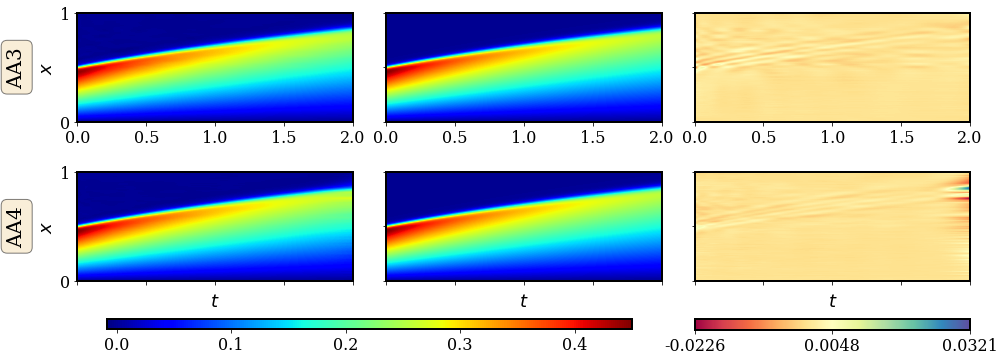

In [23]:
## Compare shifted snapshots predictions with two AA models
ky = soln_names[0]; 
np.random.seed(2021)
# imnum1 = 'AA3'; imnum2 = 'AA4'
# p_inx = 0

pu.plot_spcaetime_1d(pred_recon_new[imnum1][p_inx][ky],snap_new[p_inx][ky],
                  pred_recon_new[imnum2][p_inx][ky],snap_new[p_inx][ky],
                  label1 = imnum1, label2 = imnum2)

# plt.savefig(fig_dir+'%s_%s_Re%.1f_AErecon_swish_NMSE.png'%(model,mnum1+mnum2,Re_new[p_inx]),
#             dpi=300,bbox_inches='tight')




In [24]:
if new_test:
    ## Compute rel error for decoded prediction of shifted solutions
    rel_err_shift_new = {}
    rel_err_recon_new = {}
    key = 'burgers'
    shift_max_new = np.zeros(len(param_test))
    recon_max_new = np.zeros(len(param_test))
    for imnum in ['AA3', 'AA4']:
        rel_err_shift_new[imnum] = {}
        rel_err_recon_new[imnum] = {}
        for inx,val in enumerate(param_test):

            true_new = shifted_snap_new[inx][key][:,:snap_end_new[inx]+1]
            true2_new = snap_new[inx][key][:,:snap_end_new[inx]+1]
            rel_err_shift_new[imnum][inx] = np.linalg.norm(pred_shift_new[imnum][inx][key][:,:]-true_new,axis=0)/np.linalg.norm(true_new,axis=0)
            rel_err_recon_new[imnum][inx] = np.linalg.norm(pred_recon_new[imnum][inx][key][:,:]-true2_new,axis=0)/np.linalg.norm(true2_new,axis=0)
        
    t_end = 15
    for inx,val in enumerate(param_test):
        shift_max_new[inx] = np.maximum(np.amax(rel_err_shift_new['AA3'][inx][:-t_end]), np.amax(rel_err_shift_new['AA4'][inx][:-t_end]))
        recon_max_new[inx] = np.maximum(np.amax(rel_err_recon_new['AA3'][inx][:-t_end]), np.amax(rel_err_recon_new['AA4'][inx][:-t_end]))


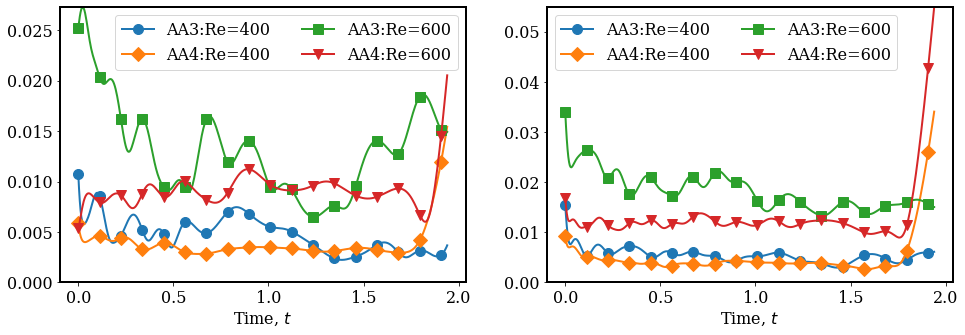

In [25]:
if new_test:
    ### Visualize relative errors for both decoders

    fig = plt.figure(figsize=(16,5))
    fig.tight_layout()
    fig.subplots_adjust(top=0.89)
    mkrlist = itertools.cycle(['o','D','s','v'])
    
    y_max_shift_new = shift_max_new.max() 
    y_max_recon_new = recon_max_new.max()
    ax1 = plt.subplot(1,2,1)
    for inx,val in enumerate(param_test):
        indx = times_new[inx][:snap_end_new[inx]+1]
        e_inx = indx.size - t_end
        ax1.plot(indx[:e_inx],rel_err_shift_new[mnum1][inx][:e_inx], label='%s:%s=%.0f'%(mnum1,flag,val),
                 marker=next(mkrlist), markevery=28,markersize=10,)
        ax1.plot(indx[:e_inx],rel_err_shift_new[mnum2][inx][:e_inx], label='%s:%s=%.0f'%(mnum2,flag,val),
                 marker=next(mkrlist), markevery=28,markersize=10,)
    ax1.set_ylim(top=y_max_shift_new, bottom=0.0)
    ax1.legend(ncol=2,loc='upper right'); ax1.set_xlabel('Time, $t$')
        
        
    ax2 = plt.subplot(1,2,2)
    for inx,val in enumerate(param_test):
        indx = times_new[inx][:snap_end_new[inx]+1]
        e_inx = indx.size -t_end
        ax2.plot(indx[:e_inx],rel_err_recon_new[mnum1][inx][:e_inx], label='%s:%s=%.0f'%(mnum1,flag,val),
                 marker=next(mkrlist), markevery=28,markersize=10,)
        ax2.plot(indx[:e_inx],rel_err_recon_new[mnum2][inx][:e_inx], label='%s:%s=%.0f'%(mnum2,flag,val),
                 marker=next(mkrlist), markevery=28,markersize=10,)
    ax2.set_ylim(top=y_max_recon_new, bottom=0.0)
    ax2.legend(ncol=2,loc='upper left'); ax2.set_xlabel('Time, $t$')   

# plt.savefig(fig_dir+'%s_%s_par%s_TestAErel_err_swish_NMSE.png'%(model,mnum1+mnum2,flag),dpi=300,bbox_inches='tight')

